# Introduction to Scikit-Learn and Pandas
Artifical Intelligence and Machine Learning Symposium at OU  
Univeristy of Oklahoma Memorial Union Ballroom  
September 25, 2019  
Instructor: Monique Shotande <monique.shotande@ou.edu>  

## Overview: Classification
Effect of Training/Test size on performance intrepretation  
Model selection using Cross Validation  
Making categorical predictions  
Evaluating model's generalized performance with Cross Validation    

### General References
* [Sci-kit Learn API](https://scikit-learn.org/stable/modules/classes.html)


## IMPORTS

In [1]:
# The copy of UCI ML Breast Cancer Wisconsin (Diagnostic) dataset is
# downloaded from: https://goo.gl/U2Uwz2
from sklearn.datasets import load_breast_cancer

import numpy as np
import pandas as pd
import scipy.stats as stats
import itertools 
import time

from matplotlib import rcParams, pyplot as plt
from itertools import product
from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve

from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, SGDRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler

%reload_ext autoreload
%autoreload 2

rcParams['figure.figsize'] = (8.0, 8.0)

globalStart = time.time()

## LOAD AND SETUP DATA

In [2]:
# Load dat set
data = load_breast_cancer()

# Setup variables
X = data.data
y = data.target

feature_names = list(data.feature_names)
target_names = list(data.target_names)
all_varnames = feature_names + ['tumor_class']

print("SETUP")
print(X.shape, y.shape)
print("Features: \n" + str(feature_names))
print("Targets: \n" + str(target_names))

SETUP
(569, 30) (569,)
Features: 
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Targets: 
['malignant', 'benign']


In [3]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

## BRIEF DATA PREPROCESSNG

In [25]:
"""
Check data for any NaNs or infinite values
"""
Xy = np.append(X, y.reshape(-1,1), axis=1)
df_Xy = pd.DataFrame(Xy, columns=all_varnames)
print("Any NaNs?", np.any(np.isnan(Xy)))
print("Any Infs?", np.any(np.isinf(Xy)))

Any NaNs? False
Any Infs? False


## BRIEF DATA VISULAIZATION AND TRANSFORMATION

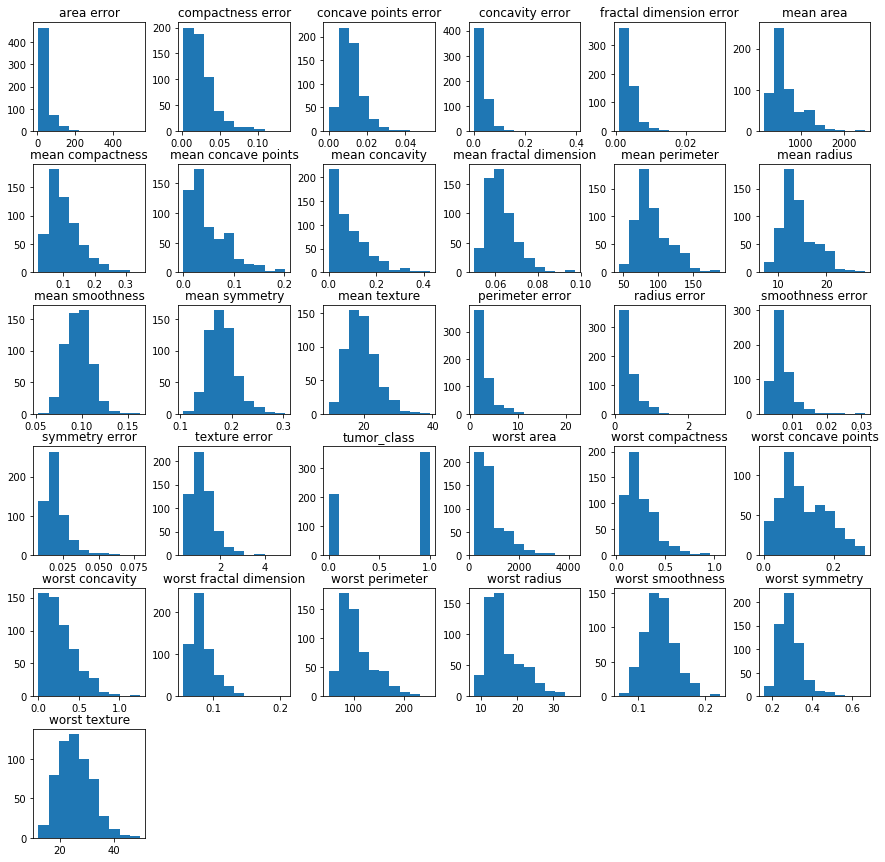

In [5]:
df_Xy.hist(grid=False, figsize=(15,15))
a = 1

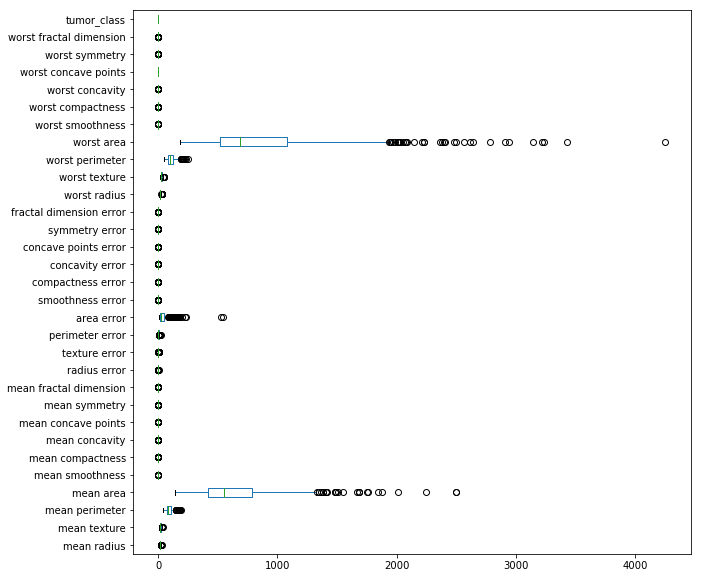

In [6]:
df_Xy.boxplot(vert=False, grid=False, figsize=(10,10))
a = 1

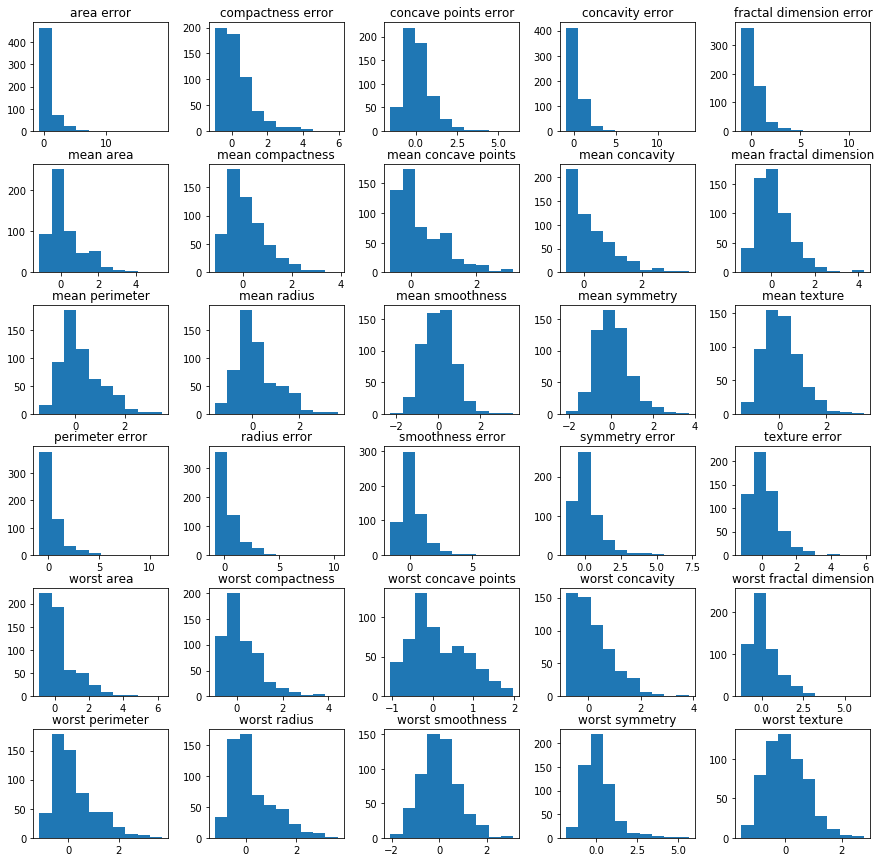

In [7]:
"""
Robustly scale data to mitigate for outliers
"""
robustscaler = RobustScaler()
Xscaled = robustscaler.fit_transform(X)

df_xs = pd.DataFrame(Xscaled, columns=feature_names)
df_xs.hist(grid=False, figsize=(15,15))
a = 1

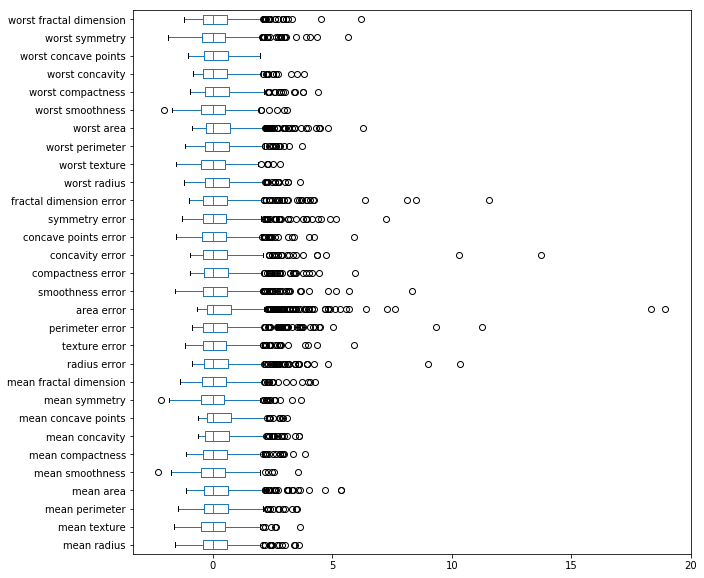

In [8]:
df_xs.boxplot(vert=False, grid=False, figsize=(10,10))
a = 1

## SCORE COMPUTATION FUNCTIONS
Define a set of helper functions here that can compute various skill scores, to use when evaluating and comparing models.
Accuracy is not always the best metric for accessing profinecy of a model, especially in the case of largely unbalanced datasets where the relative occurence of one class, is signifanctly larger than that of other classes.
Generally, a skill score will measure the relative improvement of the forecast over some benchmark forecast.  


$RB=\frac{ \sum_{t=1}^{N} (f_t-o_t) }{ \sum_{t=1}^{N} o_t }$

$BS=\frac{1}{N} \sum_{t=1}^{N} (f_t-o_t)^2$

* $f_t$: forecast probability for instance t
* $o_t$: actual event outcome at instance t; 0 for no occurance, 1 for an occurance



$PSS=tpr-tpr= \frac{tp}{tp+fn} - \frac{fp}{tn+fp}$

$precision= \frac{tp}{tp+fp}$  
* The ability of the classifier to not label negative samples as positive.

$recall= \frac{tp}{tp+fn}$  
* The ability of the classifier to find all the positive samples.



$f_1 score= 2 \frac{precision * recall}{precision+recall}$  
* The weighted harmonic mean of the precision and recall. Best value is 1 and worst 0.


References:  
* [Forecast Skill](https://en.wikipedia.org/wiki/Forecast_skill)  
* [Brier Score (BS)](https://en.wikipedia.org/wiki/Brier_score)  
* [Glossary of Forecast Verification Statistics](https://www.nws.noaa.gov/oh/rfcdev/docs/Glossary_Forecast_Verification_Metrics.pdf)  
* [Scoring Rule](https://en.wikipedia.org/wiki/Scoring_rule)  
* [Forecast Evaluation](http://www.atmos.albany.edu/daes/atmclasses/atm401/spring_2014/Scores1.pdf)  
* [Introduction to Forecast Vefrification](https://dtcenter.org/met/users/docs/presentations/WRF_Users_2012.pdf)
* [Precision Recall F1-Score Support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support)
* [F1 SCore](https://en.wikipedia.org/wiki/F1_score)

In [9]:
def skillScore(y_true, y_pred, skill='pss'):
    """
    Compute various skill scores
    PARAMS:
        y_true: the true classification label
        y_pred: the classification predicted by the model (must be binary)
        skill: a string used to select a particular skill score to compute
                'pss' | 'hss' | 'bss'
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    if skill == 'acc': #accuracy
        return float(tp+tn) / (tp+fn+tn+fp)
    if skill == 'pss':
        tpr = float(tp) / (tp + fn)
        fpr = float(fp) / (fp + tn)
        pss = tpr - fpr
        return  [pss, tpr, fpr] 
    if skill == 'hss': #Heidke
        return 2.0 * (tp*tn - fp*fn) / ((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    if skill == 'bss': #Brier Skill Score
        return np.mean(y_true - y_pred)


## PLOTTING FUNCTIONS

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    PARAMS:
        cm: the confusion matrix
        classes: list of unique class labels
    """
    # View percentages
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_mtx', bbox_inches="tight")


def plotTreeFeatImp(tree, X, feature_names):
    """
    Plots bar charts of the feature importance
    The importance of a feature is computed as the (normalized) total reduction of the 
    criterion brought by that feature. It is also known as the Gini importance
    """
    n_feature = X.shape[1]
    plt.figure(figsize=(10,8))
    plt.barh(range(0, n_feature*8, 8), tree.feature_importances_, 5, align='center')
    plt.yticks(np.arange(0, n_feature*8, 8), feature_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.show()


In [11]:
# Compute the ROC Curve and generate the KS plot
def ks_roc_plot(targets, predictions, FIGWIDTH=10, FIGHEIGHT=5, FONTSIZE=16):
    ''' 
    Generate a figure that plots the ROC Curve and the distributions of the 
    TPR and FPR over a set of thresholds
    PARAMS:
        targets: list of true target labels
        predictions: list of predicted labels
    RETURNS:
        fpr: false positive rate
        tpr: true positive rate
        thresholds: thresholds used for the ROC curve
        auc: Area under the ROC Curve
        fig, axs: corresponding handles for the figure and axis
    '''
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    auc_res = auc(fpr, tpr)

    # Generate KS plot
    fig, ax = plt.subplots(1, 2, figsize=(FIGWIDTH,FIGHEIGHT))
    axs = ax.ravel()
    ax[0].plot(thresholds, tpr, color='b')
    ax[0].plot(thresholds, fpr, color='r')
    ax[0].plot(thresholds, tpr - fpr, color='g')
    ax[0].invert_xaxis()
    ax[0].set_xlabel('threshold', fontsize=FONTSIZE)
    ax[0].set_ylabel('fraction', fontsize=FONTSIZE)
    ax[0].legend(['TPR', 'FPR', 'K-S Distance'], fontsize=FONTSIZE)
    
    # Generate ROC Curve plot
    ax[1].plot(fpr, tpr, color='b')
    ax[1].plot([0,1], [0,1], 'r--')
    ax[1].set_xlabel('FPR', fontsize=FONTSIZE)
    ax[1].set_ylabel('TPR', fontsize=FONTSIZE)
    ax[1].set_aspect('equal', 'box')
    auc_text = ax[1].text(.05, .95, "AUC = %.4f" % auc_res, 
                          color="k", fontsize=FONTSIZE)
    #print("AUC:", auc_res)

    return fpr, tpr, thresholds, auc_res, fig, axs


## FUNCTIONS FOR COMPUTING AVERAGE ACCURACY FOR VARIOUS SUBSETS OF THE TRAINING DATA
##### PART (b) continued

In [12]:
def trainSizes(estimator, X, y, sizes):
    """
    PARAMS:
        estimator: model to learn
        X: all feature data
        y: all labels
        sizes: list of test sizes, as percentage of whole data
    """
    train_test_acc = np.empty((0,2), float)

    for tsize in sizes:
        ''' 
        Note: the term estimater and model are used interchangebly
        Note: the underscores acts as blanks for you to replace with your code. Make sure to remove the 
              underscores once you've completed the TODO
        '''
        # 4.1. TODO : partition the data (X and y) into training and testing sets
        #        see documentation for train_tes_split() at
        #        https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                            test_size=tsize)

        # 4.2. TODO: Train model, use estimator.fit(X_train, y_train)
        estimator.fit(X_train, y_train)

        # 4.3. TODO: Compute the predictive score for the training set
        trng_acc = estimator.score(X_train, y_train)
        # 4.4. TODO: Compute the predictive score for the testing set
        test_acc = estimator.score(X_test, y_test)

        train_test_acc = np.append(train_test_acc, np.array([[trng_acc, 
                                                              test_acc]]), axis=0)

    return train_test_acc


def avgTrainSizes(estimator, X, y, sizes, nsamples=25):
    """
    Average and plot the accuracy for each size in sizes
    PARAMS:
        estimator: model to learn
        X: all feature data
        y: all labels
        sizes: list of test sizes, as percentage of whole data
        nsamples: number of times to compute the accuracy for each size
    """
    train_test_acc = np.zeros((len(sizes),2), float)

    for samp in range(nsamples):
        ttacc = trainSizes(estimator, X, y, sizes)
        train_test_acc += ttacc

    train_test_acc = train_test_acc / nsamples

    plt.plot(sizes, train_test_acc[:,0], 'o-', color="b", label="train")
    plt.plot(sizes, train_test_acc[:,1], 'o--', color="r", label="test")
    plt.title("Average Accuracy")
    plt.xlabel("Test Size (%)")
    plt.ylabel("Accuracy")
    plt.legend()

    return train_test_acc


## GRID SEARCH FUNCTIONS

In [13]:
def pss(true, preds):
    pss, tpr, fpr = skillScore(true, preds, skill='pss')
    return pss


def performGridSearchCV(estimator, param_grid, X, y, scoring={'PSS':make_scorer(pss)}, 
                        refit='PSS', cv=10, test_size=0.25, cvalfunc=None):
    """
    PARAMS:
        estimator: the model to build
        param_grid: space of parameters to search
        X: all feature data 
        y: all target data 
        refit: the name of the function to use for scoring. these functions must return 
               only 1 value (default PSS)
        cv: number of cross validation folds
        test_size: proportion of the data to hold out for testing
        scoring: See https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                 sets the scoring function to pss to compare models 
    """
    clf = GridSearchCV(estimator, param_grid, cv=cv, scoring=scoring, refit=refit, iid=True)

    # Hold out a subset of the data for testing, before training, usimg cross validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size)
    clf.fit(X_train, y_train)

    print("Best parameters set found:")
    print(clf.best_params_)

    print("\nGrid scores:")
    means = clf.cv_results_['mean_test_%s' % refit]
    stds = clf.cv_results_['std_test_%s' % refit]
    dets = [] # used for tracking the order of the models by mean score
    for i, (mean, std, params) in enumerate(zip(means, stds, clf.cv_results_['params'])):
        print("%03d: %0.3f (+/-%0.03f) for %r" % (i, mean, std * 2, params))
        dets.append((mean, i))
    dets.sort()
    means.sort()
    
    print("\nDetailed classification report:")
    print("The model is trained on the full set using the best parameters.")
    print("The scores are computed on the full evaluation set.")
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    
    # Plotting
    cmtx = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cmtx, target_names)
    
    if not (cvalfunc is None):
        scores = cross_val_predict(clf.best_estimator_, X_test, y_test, 
                                   cv=cv, method=cvalfunc) #decision_function
        fpr, tpr, thresholds, auc_res, fig, axs = ks_roc_plot(y_test, scores) ###
        print("AUC:", auc_res)
    
    plt.figure()
    plt.plot(means)
    plt.ylabel('Mean %s'% refit)
    plt.xlabel('Parameter Set #')
    plt.title('')
    plt.savefig('mean_%s_plot' % refit, bbox_inches="tight")
    
    return dets, clf


def performGridRegressionSearchCV(estimator, paramsdict, thres, X, y, nsplits=3, test_size=0.25):
    """
    Grid search for regression. 
    Optimizes over the parameter space and a set of decision thresholds for classification
    PARAMS:
        estimator: type of model 
        paramsdict: space of parameters to search
        thres: set of thresholds to use
        X: all feature data 
        y: all target data 
        nsplits: number of cross validation folds
        test_size: proportion of the data to hold out for testing
    """
    paramnames = paramsdict.keys()
    paramvals = paramsdict.values()
    
    # Determine all the permutations of parameters
    allparamsets = list(product(*paramvals))
    nprmsets = len(allparamsets)
    #thres = np.arange(-.1,.6,.04)

    models_tpr = np.zeros((nprmsets,nsplits,len(thres)), float)
    models_fpr = np.zeros((nprmsets,nsplits,len(thres)), float)
    models_auc = np.zeros((nprmsets,nsplits), float)

    # Perform stratified k fold cross validation
    skf = StratifiedKFold(n_splits=nsplits)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size)
    for s, (train, val) in enumerate(skf.split(X_train, y_train)):
        for p, paramset in enumerate(allparamsets):
            currparams = dict( zip(paramnames, paramset) )

            # Train
            estimator.set_params(**currparams)
            estimator.fit(X_train[train,:], y_train[train])

            # Validate the Model
            preds = estimator.predict(X_train[val,:])
            models_auc[p,s] = roc_auc_score(y_train[val], preds)

            # Determine the labels for different thresholds
            inds = [np.where(preds > t)[0] for t in thres]
            # Compute PSS for different thresholds
            for t, i in enumerate(inds):
                prd = np.zeros(preds.shape, float)
                prd[i] = 1 
                pss, tpr, fpr = skillScore(y_train[val], prd, skill='pss')
                models_tpr[p,s,t] = tpr
                models_fpr[p,s,t] = fpr

    # Compute average PSS across the folds for each threshold for all models
    psses = models_tpr - models_fpr
    avg_pss = np.mean(psses, axis=1)
    avg_auc = np.mean(models_auc, axis=1)
    avg_tpr = np.mean(models_tpr, axis=1)
    avg_fpr = np.mean(models_fpr, axis=1)

    mIdx = np.argmax(avg_auc) # get the index of the best parameter set
    best_params = dict( zip(paramnames, allparamsets[mIdx])) # constructs a parameter dict
    tIdx = np.argmax(avg_pss[mIdx]) # get the decision threshold

    # ROC axes
    fpr = avg_fpr[mIdx,:]
    tpr = avg_tpr[mIdx,:]

    #plt.figure()
    #plt.plot(fpr, tpr)
    #plt.title('ROC Curve')
    #plt.ylabel('Average TPR')
    #plt.xlabel('Average FPR')
    #plt.savefig('bestparams_roc', bbox_inches="tight")
    #plt text of AUC on plot

    # Construct model from all the training data, using the best parameters
    estimator.set_params(**best_params)
    estimator.fit(X_train, y_train)
    
    # Test the model and make the predictions binary
    preds = estimator.predict(X_test)
    preds[preds > thres[tIdx]] = 1
    preds[preds <= thres[tIdx]] = 0
    
    # Confusion Matrix
    cmtx = confusion_matrix(y_test, preds)
    plot_confusion_matrix(cmtx, target_names)
    
    # Training statistics for the best threshold and parameter set
    b_avg_pss = np.mean(models_tpr[mIdx,:,tIdx] - models_fpr[mIdx,:,tIdx])
    b_std_pss = np.std(models_tpr[mIdx,:,tIdx] - models_fpr[mIdx,:,tIdx])
    
    print ("Best Parameters")
    print (best_params)
    print ("Average Training PSS %.04f" % b_avg_pss)
    print ("STD Training PSS %.04f" % b_std_pss)
    print ("Best Model Test PSS %.04f" % skillScore(y_test, preds, 'pss')[0])
    print ("Best Model Test Accuracy %.04f" % skillScore(y_test, preds, 'acc'))
    
    return estimator


## CLASSIFICATION

### PART 1 (a)
Simple training and testing of a standard model

In [14]:
### PART 1 (a)
# 1. TODO: create a SVC model that uses a linear kernel and gamma set to 'auto'
t0 = time.time()
svc_a = SVC(kernel='linear', gamma='auto')

# 2. TODO: Split the data into training and testing sets.  ****
#    Use train_test_split
#    Select a portion to hold out for testing
#    Additionally, stratify the splits
#    see the documentation for more details at
#    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

# 3. TODO: Train the model using the training data
svc_a.fit(X_train, y_train)

# 4. TODO: Computing the predictive accuracy of the train set
trng_acc = svc_a.score(X_train, y_train)
# 5. TODO: Computing the predictive accuracy of the test set
test_acc = svc_a.score(X_test, y_test)

t1 = time.time()
et = t1 - t0

# Print out the training accuracy, testing accuracy, and the portion of the data used for testing
print ("Train Accuracy %.04f" % trng_acc)
print ("Test Accuracy %.04f" % test_acc)
print ("Test portion .25")
print ("Elapsed time: %.03f min" % (et / 60))

Train Accuracy 0.9623
Test Accuracy 0.9532
Test portion .25
Elapsed time: 0.004 min


### PART 1 (b)
Explore the impact of using different portions of your data set for training and testing.
Instead of trying various values for test_size manually, we will use a function to try a range of values.
Because there can be variation in the accuracy from using different subsets of the data for training, we will compute the average accuracy for each portion as well.

You will use the *avgTrainSize* function for this purpose (also see *trainSizes* function). 

Elapsed time: 1.555 min


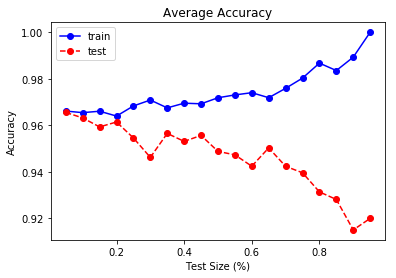

In [15]:
### PART 1 (b)
# 1. TODO: create the SVC model with a linear kernel and gamma set tot 'auto'
t0 = time.time() # get the start time this cell is run
svc_b = SVC(kernel='linear', gamma='auto')

# 2. TODO: adjust the test size range as needed
tsizes = np.arange(.05, 1, .05)

# 3. TODO: Pass the model into the function. 
#    Feel free to adjust the nsamples as you see fit. This is the number of times the accuracy
#    is computed for the same test set portion size, but instead using a different training set
#    to learn the model
avgTrainSizes(svc_b, X, y, tsizes, nsamples=10) #

# 4. Go to the function trainSizes, defined above and read it

et = time.time() - t0 # compute the end time
print ("Elapsed time: %.03f min" % (et / 60))

Elapsed time: 0.038 min


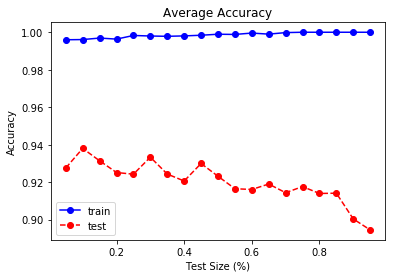

In [16]:
### Decision Trees
# 1. TODO: create DecisionTreeClassifier
t0 = time.time()
dtc_b = DecisionTreeClassifier(max_depth=6, min_samples_split=2)

# 2. TODO: adjust the test size range as needed
tsizes = np.arange(.05, 1, .05) # nsamples=30  0.038 min

# 3. TODO: Pass the model into the function. 
#    Feel free to adjust the nsamples as you see fit. This is the number of times the accuracy
#    is computed for the same test set portion size, but instead using a different training set
#    to learn the model
avgTrainSizes(dtc_b, X, y, tsizes, nsamples=30)

# 4. Compare the plots for SVCs and DecisionTrees

et = time.time() - t0 # compute the end time
print ("Elapsed time: %.03f min" % (et / 60))

## CLASSIFICATION - GRID SEARCH AND CROSS VALIDATION

### PART 2 (a)
Try a few (about 3) combinations of parameters for the SVC, DecisionTree, or RandomForest models.
For the SVR or SGDRegressor, since these are regressive technique, a continous value is returned from prediction instead of a class label. You will need to select a threshold, such that any predictions exceeding the threshold hold will be given label 1, otherwise 0.

Confusion matrix, without normalization
[[39  3]
 [ 4 68]]
Train PSS 0.9307
TEst PSS 0.8730
Elapsed time: 0.041 min


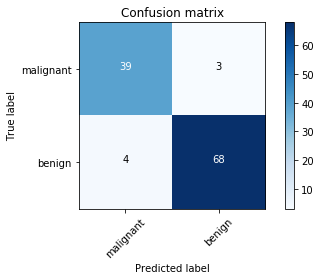

In [27]:
### PART 2 (a) CLASSIFICATION
# 1. TODO: create a SVC model with some parameter configuration
#    See the parameters list https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
t0 = time.time() 
svc_p2 = SVC(kernel='linear', gamma='auto', C=10)

# 2. TODO: Use the plot from PART 1 to determine a reasonable portion of the data to hold out for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

# 3. TODO: Train the model on the train set
svc_p2.fit(X_train, y_train)

# 4. TODO: Test the model's predictive ability with the test set
preds = svc_p2.predict(X_test)

# 5. TODO: Evalutate the model using the Pierce Skill Score (PSS) 
#    Pass to the function the true and the predicted labels
pss_test, _, _ = skillScore(y_test, preds, skill='pss')

# Compute predictive abilities on the training set. Not a good metric as the model is overfit
preds_train = svc_p2.predict(X_train)
pss_train, _, _ = skillScore(y_train, preds_train, skill='pss')

# 6. TODO: Construct and draw a Confusion Matrix
#    This is used to observe the relationship between correct and incorrect predictions relative to class
#    Pass to the function the true and the predicted labels
cmtx = confusion_matrix(y_test, preds)
plot_confusion_matrix(cmtx, target_names)
et = time.time() - t0 # compute the end time

# Print out the pss result
print ("Train PSS %.04f" % pss_train)
print ("TEst PSS %.04f" % pss_test)
print ("Elapsed time: %.03f min" % (et / 60))

### PART 2 (b)
Repeat (a) for regression models such as the SVR.
For prediction regression models predict a continous value instead of a class label.
You will need to select a threshold, such that any predictions exceeding the threshold hold wiill be given label 1, otherwise 0.

-1.5265 to 5.6059
Confusion matrix, without normalization
[[62  2]
 [41 66]]
PSS 0.5856 using 0.90
Elapsed Time: 2.207 min


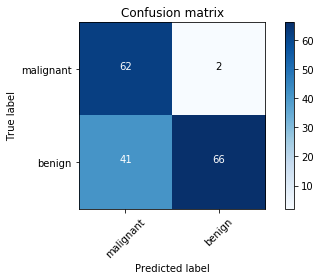

In [26]:
### PART 2 (b) CLASSIFICATION w REGRESSION MODEL
# 1. TODO: Repeat the TODO steps 1 to 3 from (a), the SVR model
# Parameters list, https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
# 1.1. TODO: create a SVR model with some parameter configuration
#    See the parameters list https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
t0 = time.time()
svr_2b = SVR(kernel='linear', C=.8)

# 1.2. TODO: Use the plot from PART 1 to determine a reasonable portion of the data to hold out for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

# 1.3. TODO: Train the model on the train set
svr_2b.fit(X_train, y_train)

# 1.4. TODO: Test the model with the test set
preds = svr_2b.predict(X_test)

# Observe the range of predicted values
print ("%.04f to %.04f" % (np.min(preds), np.max(preds)))

# 2. TODO: From the range printed above, pick a value in between to act as a deciding threshold.
thres = .9 # not optimal choice

# 3. TODO: Determine the label. If the vale is > thres, set the label to 1, otherwise it's 0.
#    Place the thres value
preds_labels = [int(p > thres) for p in preds]

# 5. TODO: Compute the pss
#    Pass to the function the true and the predicted labels
pss, _, _ = skillScore(y_test, preds_labels, skill='pss')

# Confusion Matrix
cmtx = confusion_matrix(y_test, preds_labels) # NOTE: must use the binary labels
plot_confusion_matrix(cmtx, target_names)
et = time.time() - t0
    
# Print the pss, and threshold value
print ("PSS %.04f using %.02f" % (pss, thres))
print ("Elapsed Time: %.03f min" % (et / 60)) # 

### PART 2 (c)
Perform an exhaustive search of all permutations of a set of parameters and thresholds using the functions *performGridSearchCV*, for classification models and *performGridRegressionSearchCV* for regression models

Best parameters set found:
{'loss': 'perceptron', 'max_iter': 10000.0, 'penalty': 'elasticnet', 'tol': 0.001}

Grid scores:
000: 0.740 (+/-0.329) for {'loss': 'log', 'max_iter': 10000.0, 'penalty': 'l2', 'tol': 0.001}
001: 0.776 (+/-0.344) for {'loss': 'log', 'max_iter': 10000.0, 'penalty': 'l1', 'tol': 0.001}
002: 0.750 (+/-0.424) for {'loss': 'log', 'max_iter': 10000.0, 'penalty': 'elasticnet', 'tol': 0.001}
003: 0.736 (+/-0.265) for {'loss': 'perceptron', 'max_iter': 10000.0, 'penalty': 'l2', 'tol': 0.001}
004: 0.782 (+/-0.282) for {'loss': 'perceptron', 'max_iter': 10000.0, 'penalty': 'l1', 'tol': 0.001}
005: 0.810 (+/-0.338) for {'loss': 'perceptron', 'max_iter': 10000.0, 'penalty': 'elasticnet', 'tol': 0.001}

Detailed classification report:
The model is trained on the full set using the best parameters.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1     

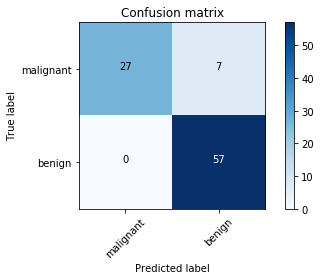

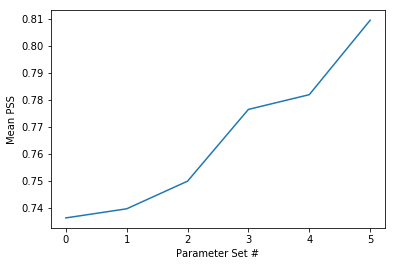

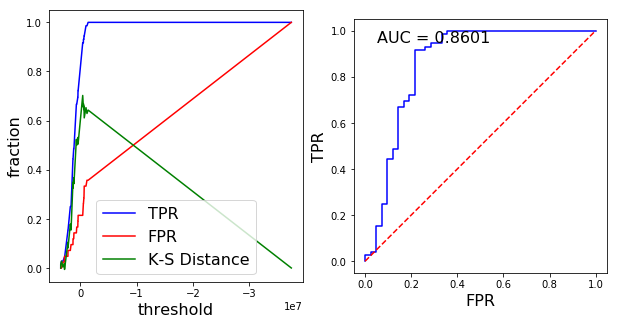

In [19]:
### PART 2 (c) CLASSIFICATION
# construct a model with no parameters
t0 = time.time()
sgd_model = SGDClassifier()

# 1. TODO: Select parameters and values to explore for the model. Make adjustments as you see fit
param_grid = {'loss': ['log', 'perceptron'], 'penalty':['l2', 'l1', 'elasticnet'], 
              'max_iter':[1e4], 'tol':[1e-3]} #

# 2. TODO: Pass the model and then the parameter options into performGridSearchCV 
#    Adjust cv as you see fit (note: cv should by > 2)
#    Adjust test_size as you see fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
dets, clf = performGridSearchCV(sgd_model, param_grid, X_train, y_train, 
                                cv=20, test_size=.2)

# 3. TODO: Cross validation on test performance of the best estimator
preds = cross_val_predict(clf.best_estimator_, X_test, y_test, cv=20, method='decision_function')
fpr, tpr, thresholds, auc_res, fig, axs = ks_roc_plot(y_test, preds) 

et = time.time() - t0
print ("Elapsed time: %.03f min" % (et / 60))

# The list of parameters can be obtained with 
# >> for i, params in enumerate(clf.cv_results_['params']):
# >>     print("%03d: %r" % (i, params))

Best parameters set found:
{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}

Grid scores:
000: 0.893 (+/-0.213) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
001: 0.000 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
002: 0.893 (+/-0.213) for {'C': 0.1, 'gamma': 100.0, 'kernel': 'linear'}
003: 0.000 (+/-0.000) for {'C': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}
004: 0.895 (+/-0.203) for {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
005: 0.030 (+/-0.119) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
006: 0.895 (+/-0.203) for {'C': 10, 'gamma': 100.0, 'kernel': 'linear'}
007: 0.000 (+/-0.000) for {'C': 10, 'gamma': 100.0, 'kernel': 'rbf'}

Detailed classification report:
The model is trained on the full set using the best parameters.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        34
           1       0.96      0.96      0.96        57

   micro avg       0.96      0.96    

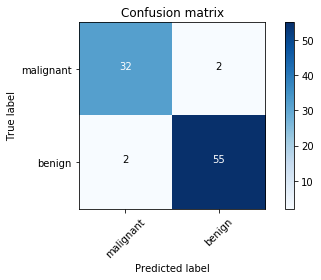

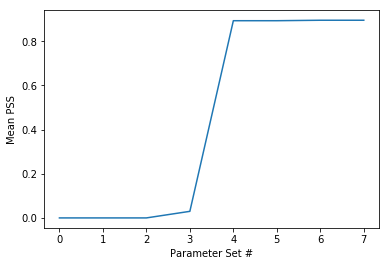

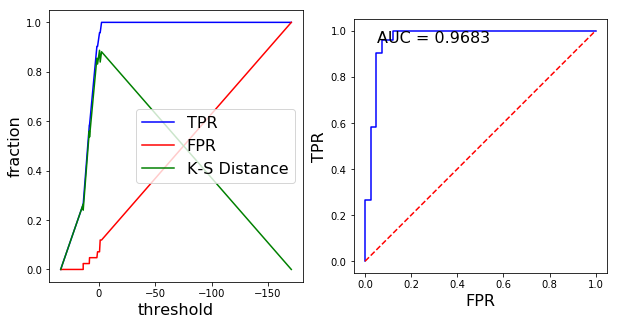

In [20]:
### PART 2 (c)
# construct a model with no parameters
t0 = time.time()
svc_model = SVC()

# 1. TODO: Select parameters and values to explore for the model. Make adjustments as you see fit
param_grid = {'C': [.1, 10], 'gamma': np.logspace(-2, 2, 2), 'kernel':['linear','rbf']} # ~1 min


# 2. TODO: Pass the model and then the parameter options into performGridSearchCV 
#    Adjust cv as you see fit (note: cv should by > 2)
#    Adjust test_size as you see fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
dets, clf = performGridSearchCV(svc_model, param_grid, X_train, y_train, cv=20, test_size=.2)#, cvalfunc='decision_function')

# Cross validation on test performance of the best estimator
preds = cross_val_predict(clf.best_estimator_, X_test, y_test, cv=20, method='decision_function')
fpr, tpr, thresholds, auc_res, fig, axs = ks_roc_plot(y_test, preds) ###


et = time.time() - t0
print ("Elapsed time: %.03f min" % (et / 60))

#### DECISION TREE CLASSIFIER - GRID SEARCH, CROSS VALIDATION AND FEATURE IMPORTANCE

Best parameters set found:
{'max_depth': 5, 'min_samples_split': 7}

Grid scores:
000: 0.873 (+/-0.221) for {'max_depth': 5, 'min_samples_split': 3}
001: 0.876 (+/-0.202) for {'max_depth': 5, 'min_samples_split': 5}
002: 0.883 (+/-0.205) for {'max_depth': 5, 'min_samples_split': 7}
003: 0.875 (+/-0.201) for {'max_depth': 5, 'min_samples_split': 10}
004: 0.857 (+/-0.190) for {'max_depth': 5, 'min_samples_split': 20}
005: 0.852 (+/-0.232) for {'max_depth': 8, 'min_samples_split': 3}
006: 0.874 (+/-0.186) for {'max_depth': 8, 'min_samples_split': 5}
007: 0.852 (+/-0.229) for {'max_depth': 8, 'min_samples_split': 7}
008: 0.862 (+/-0.217) for {'max_depth': 8, 'min_samples_split': 10}
009: 0.857 (+/-0.190) for {'max_depth': 8, 'min_samples_split': 20}
010: 0.848 (+/-0.202) for {'max_depth': 12, 'min_samples_split': 3}
011: 0.867 (+/-0.218) for {'max_depth': 12, 'min_samples_split': 5}
012: 0.841 (+/-0.236) for {'max_depth': 12, 'min_samples_split': 7}
013: 0.860 (+/-0.206) for {'max_depth': 

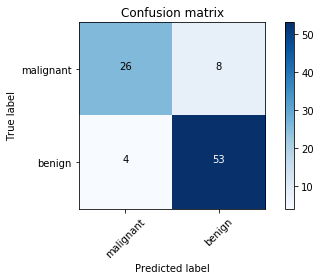

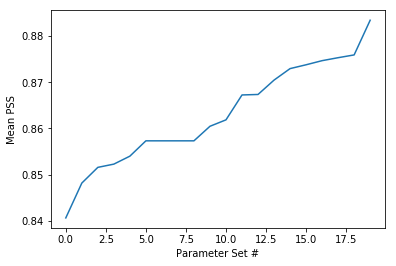

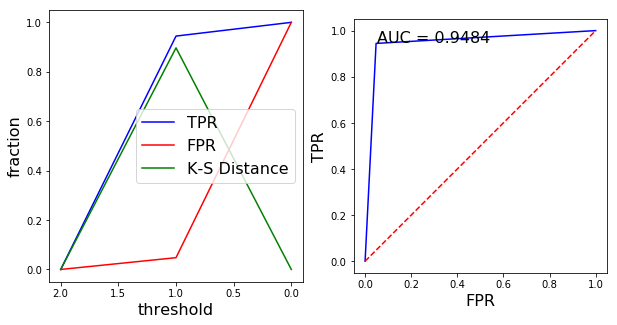

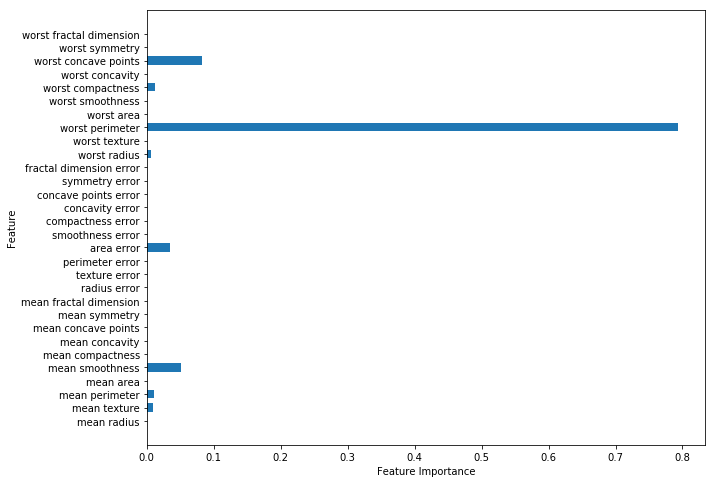

Elapsed time: 0.055 min


In [21]:
# 1. TODO: Find an optimal Decision Tree
# construct a model with no parameters
t0 = time.time()
tree_model = DecisionTreeClassifier()

# 1. TODO: Select parameters and values to explore for the model. Make adjustments as you see fit
# grid search for Trees is fast, they can choose a lot of parameters here
param_grid = {'max_depth':[5, 8, 12, 25],'min_samples_split':[3, 5, 7, 10, 20]} 


# 2. TODO: Pass the model and then the parameter options into performGridSearchCV 
#    Adjust cv as you see fit (note: cv should by > 2)
#    Adjust test_size as you see fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
dets, clf = performGridSearchCV(tree_model, param_grid, X_train, y_train, cv=20, test_size=.2)#, cvalfunc='predict_proba')

# Evaluate Generalized performance
preds = cross_val_predict(clf.best_estimator_, X_test, y_test, cv=20) 
fpr, tpr, thresholds, auc_res, fig, axs = ks_roc_plot(y_test, preds) 

# Feature Importance
plotTreeFeatImp(clf.best_estimator_, X, feature_names) 
et = time.time() - t0
print ("Elapsed time: %.03f min" % (et / 60))

#### RANDOM FOREST -  GRID SEARCH, CROSS VALIDATION AND FEATURE IMPORTANCE

Best parameters set found:
{'max_depth': 5, 'min_samples_split': 7, 'n_estimators': 60}

Grid scores:
000: 0.935 (+/-0.076) for {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 60}
001: 0.927 (+/-0.104) for {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 100}
002: 0.931 (+/-0.090) for {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 500}
003: 0.924 (+/-0.075) for {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 60}
004: 0.934 (+/-0.111) for {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
005: 0.927 (+/-0.104) for {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 500}
006: 0.943 (+/-0.082) for {'max_depth': 5, 'min_samples_split': 7, 'n_estimators': 60}
007: 0.927 (+/-0.079) for {'max_depth': 5, 'min_samples_split': 7, 'n_estimators': 100}
008: 0.927 (+/-0.104) for {'max_depth': 5, 'min_samples_split': 7, 'n_estimators': 500}
009: 0.924 (+/-0.114) for {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 60}
010: 0.909 (+/-0.096)

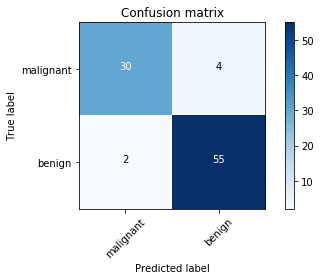

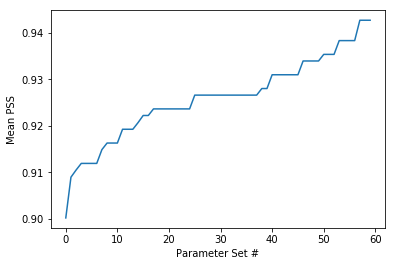

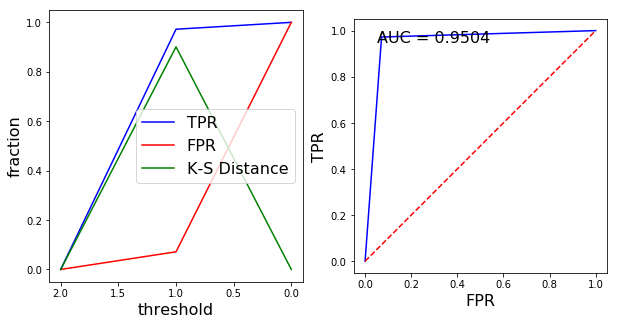

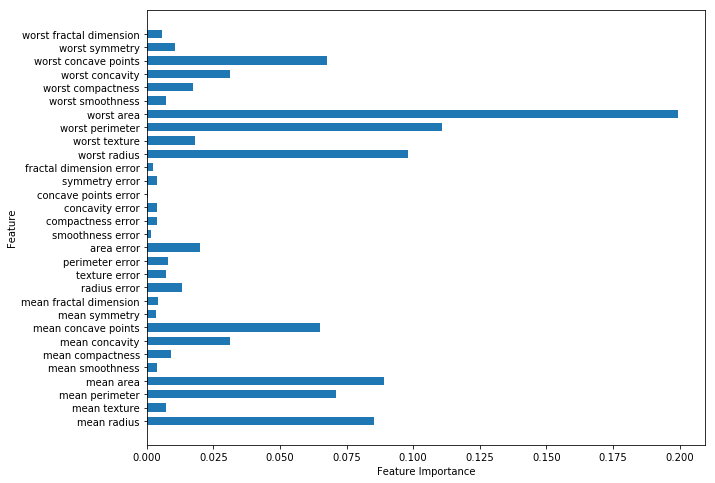

Elapsed time: 1.108 min


In [22]:
# 1. TODO: Find an optimal Random Forest
t0 = time.time()
forest_model = RandomForestClassifier()

# 1. TODO: Select parameters and values to explore for the model. Make adjustments as you see fit
# grid search for Trees is fast, they can choose a lot of parameters here
# ~1 min with cv=3; ~4 min with cv=10
param_grid = {'n_estimators':[60,100,500],'max_depth':[5, 8, 12, 25],'min_samples_split':[3, 5, 7, 10, 20]} 


# 2. TODO: Pass the model and then the parameter options into performGridSearchCV 
#    Adjust cv as you see fit (note: cv should by > 2)
#    Adjust test_size as you see fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
dets, clf = performGridSearchCV(forest_model, param_grid, X_train, y_train, cv=4, test_size=.2)
#clf.best_params_

# Evaluate Generalized performance
preds = cross_val_predict(clf.best_estimator_, X_test, y_test, cv=4) 
fpr, tpr, thresholds, auc_res, fig, axs = ks_roc_plot(y_test, preds) 

# Feature Importance
plotTreeFeatImp(clf.best_estimator_, X, feature_names) 

et = time.time() - t0
print ("Elapsed time: %.03f min" % (et / 60))

#### REGRESSION  - GRID SEARCH AND CROSS VALIDATION
Repeat (c) for regression models using *performGridRegressionSearchCV*

Confusion matrix, without normalization
[[ 0 34]
 [ 0 57]]
Best Parameters
{'loss': 'squared_loss', 'penalty': 'l1', 'max_iter': 10000.0, 'tol': 0.001, 'early_stopping': True}
Average Training PSS 0.0000
STD Training PSS 0.0000
Best Model Test PSS 0.0000
Best Model Test Accuracy 0.6264
Elapsed Time: 0.008 min


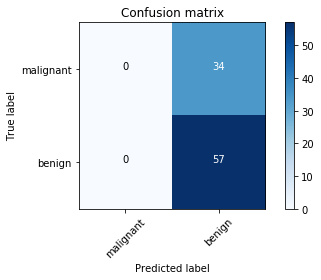

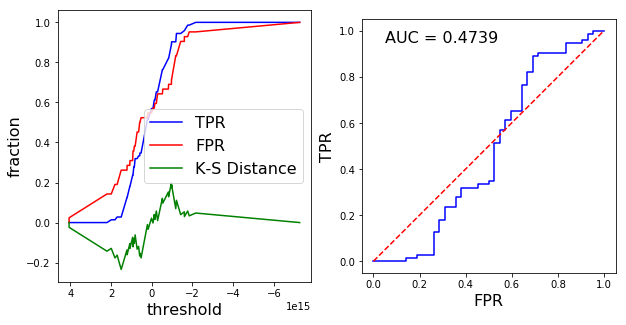

In [23]:
#### REGRESSION
# 1. TODO: Construct the  a default model with no parameters
t0 = time.time()
svr = SGDRegressor() #SVR

# 2. TODO: Select parameters and values to explore for the model. Make adjustments as you see fit
# select small param space such that this is faster. Small values for C tend to run faster
#paramsdict = {'C':[.8], 'gamma':np.logspace(-2, 2, 2), 'kernel':['linear']}#,'rbf']} # for SVR()
paramsdict = {'loss':['squared_loss', 'huber'], 'penalty':['l1','l2','elasticnet'], 
              'max_iter':[1e4], 'tol':[1e-3], 'early_stopping':[True]}
# 3. TODO: Adjust the range of thresholds to try as you see fit
thres = np.arange(-.1,1,.3)

# 4. TODO: Pass in the model, then the parameters, then the thresholds
#    Adjust nsplits as you see fit (note: nsplits should by > 2)
#    Adjust test_size as you see fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
estimator = performGridRegressionSearchCV(svr, paramsdict, thres, X_train, y_train,
                                          nsplits=4, test_size=.2)

# Evaluate Generalized performance
preds = cross_val_predict(estimator, X_test, y_test, cv=20)
fpr, tpr, thresholds, auc_res, fig, axs = ks_roc_plot(y_test, preds)

et = time.time() - t0
print ("Elapsed Time: %.03f min" % (et / 60))

In [24]:
globalET = time.time() - globalStart
print ("Elapsed Time of Notebook: %.03f min" % (globalET / 60))

Elapsed Time of Notebook: 6.039 min
